
# 🧮 Task 4: Loan Approval Prediction (End‑to‑End, Colab‑Ready)

**Goal:** Build a binary classifier to predict whether a loan application will be approved.  
**Key points:** handle missing values, encode categoricals, deal with class imbalance, and report **precision**, **recall**, and **F1-score**.  
**Bonus:** try **SMOTE** and compare **Logistic Regression** vs **Decision Tree**.

> Dataset (recommended): *Loan-Approval-Prediction-Dataset* on Kaggle.



## ✅ Setup

Run the cell below in **Google Colab**. It installs requirements and sets up basic imports.


In [10]:

# If you're on Colab, uncomment the next line to install imbalanced-learn
# !pip install -q imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import joblib
import os, textwrap
print("Libraries imported ✔️")


Libraries imported ✔️



## 📥 Load Data

Choose **one** of the options:
1) **Upload** the CSV in Colab sidebar (or `files.upload`) and set the path below.  
2) **Google Drive**: mount and point to your CSV.  
3) **Kaggle API** (optional): download directly from Kaggle if you have credentials configured.


In [11]:

# ==== OPTION 1: Direct path to your CSV (recommended if uploading in Colab) ====
CSV_PATH = "/content/loan_approval_dataset.csv"  # <- change to your uploaded file name
# ==== OPTION 2: Google Drive ====
# from google.colab import drive
# drive.mount('/content/drive')
# CSV_PATH = "/content/drive/MyDrive/path/to/loan_approval_data.csv"

# ==== OPTION 3: Kaggle API (uncomment + configure) ====
# !pip install -q kaggle
# import os
# os.makedirs('/root/.kaggle', exist_ok=True)
# # Upload kaggle.json (Account > Create New API Token), then place it at /root/.kaggle/kaggle.json
# # from google.colab import files; files.upload()
# os.chmod('/root/.kaggle/kaggle.json', 0o600)
# !kaggle datasets download -d <owner>/<dataset-slug> -p /content
# !unzip -o /content/<downloaded-file>.zip -d /content
# CSV_PATH = "/content/<actual_file>.csv"

# === Load ===
df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head()


(4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected



## 🔎 Quick Data Check


In [12]:

display(df.head())
print("\nInfo:")
print(df.info())
print("\nMissing values per column:")
print(df.isna().sum())
print("\nClass balance (target):")
# Try common target names; adjust if needed
candidate_targets = ["Loan_Status", "loan_status", "Approved", "approved", "Target", "target", "Label", "label"]
target_col = None
for c in candidate_targets:
    if c in df.columns:
        target_col = c
        break

if target_col is None:
    # Fallback: assume last column is the target
    target_col = df.columns[-1]
print("Using target column:", target_col)

print(df[target_col].value_counts(dropna=False))


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB
None

Mi


## ✂️ Split + Detect Column Types


In [13]:

# Separate features/target
y = df[target_col]
X = df.drop(columns=[target_col])

# Basic automatic type inference
numeric_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_features = [c for c in X.columns if c not in numeric_features]

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

# Train/validation split (stratified because it's imbalanced)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape


Numeric: ['loan_id', ' no_of_dependents', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value']
Categorical: [' education', ' self_employed']


((3415, 12), (854, 12))


## 🧼 Preprocessing Pipelines

- **Numerical**: Median impute → Scale  
- **Categorical**: Most frequent impute → One-hot encode


In [14]:

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
preprocessor


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['loan_id', ' no_of_dependents',
                                  ' income_annum', ' loan_amount', ' loan_term',
                                  ' cibil_score', ' residential_assets_value',
                                  ' commercial_assets_value',
                                  ' luxury_assets_value',
                                  ' bank_asset_value']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 [' education', ' self_employed'])])


## 📊 Baseline Models (No SMOTE)

We start with:
- **Logistic Regression** with `class_weight='balanced'`
- **Decision Tree** with `class_weight='balanced'`

This helps when data is imbalanced by weighting the minority class.


In [15]:

log_reg = LogisticRegression(max_iter=500, class_weight="balanced", n_jobs=None, random_state=42)
tree_clf = DecisionTreeClassifier(class_weight="balanced", random_state=42)

pipe_lr = Pipeline(steps=[("preprocess", preprocessor),
                         ("model", log_reg)])

pipe_tree = Pipeline(steps=[("preprocess", preprocessor),
                           ("model", tree_clf)])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

cv_lr = cross_validate(pipe_lr, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
cv_tree = cross_validate(pipe_tree, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

def summarize_cv(cvres, name):
    print(f"\n{name} CV metrics (mean ± std):")
    for k in scoring.keys():
        vals = cvres[f'test_{k}']
        print(f"  {k:>9}: {np.mean(vals):.4f} ± {np.std(vals):.4f}")

summarize_cv(cv_lr, "LogisticRegression (balanced)")
summarize_cv(cv_tree, "DecisionTree (balanced)")



LogisticRegression (balanced) CV metrics (mean ± std):
  precision: nan ± nan
     recall: nan ± nan
         f1: nan ± nan
    roc_auc: 0.9665 ± 0.0026

DecisionTree (balanced) CV metrics (mean ± std):
  precision: nan ± nan
     recall: nan ± nan
         f1: nan ± nan
    roc_auc: 0.9734 ± 0.0051



## 🧪 Evaluate on the Hold‑out Test Set (No SMOTE)



=== LogReg (balanced) ===
              precision    recall  f1-score   support

    Approved     0.9560    0.9416    0.9488       531
    Rejected     0.9063    0.9288    0.9174       323

    accuracy                         0.9368       854
   macro avg     0.9312    0.9352    0.9331       854
weighted avg     0.9372    0.9368    0.9369       854

Confusion matrix:
 [[500  31]
 [ 23 300]]
ROC-AUC: 0.9745
PR-AUC : 0.4108


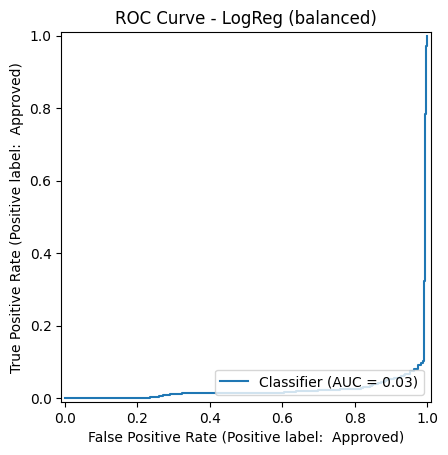

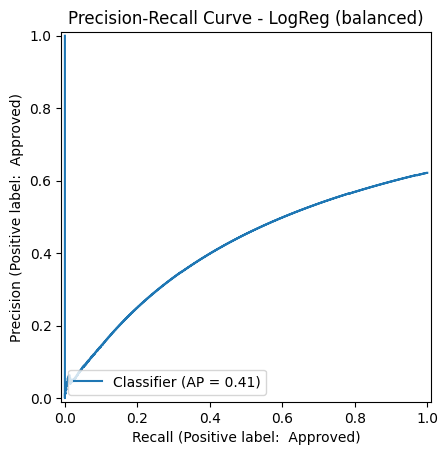


=== DecisionTree (balanced) ===
              precision    recall  f1-score   support

    Approved     0.9704    0.9868    0.9785       531
    Rejected     0.9777    0.9505    0.9639       323

    accuracy                         0.9731       854
   macro avg     0.9740    0.9686    0.9712       854
weighted avg     0.9731    0.9731    0.9730       854

Confusion matrix:
 [[524   7]
 [ 16 307]]
ROC-AUC: 0.9686
PR-AUC : 0.3245


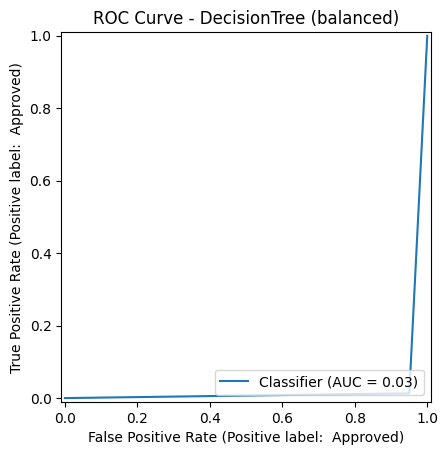

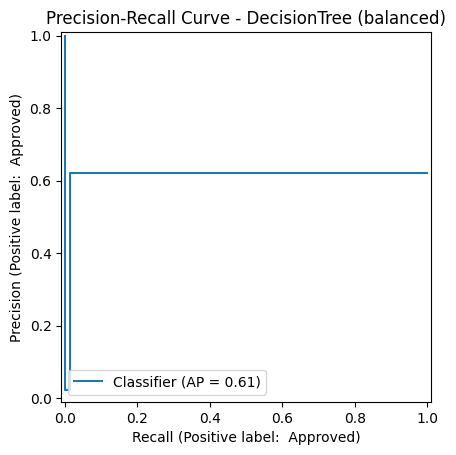

In [19]:
def evaluate_on_test(pipeline, X_train, y_train, X_test, y_test, name="Model"):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = None
    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        y_proba = pipeline.predict_proba(X_test)[:, 1]
    elif hasattr(pipeline.named_steps["model"], "decision_function"):
        # Some models expose decision_function only
        s = pipeline.decision_function(X_test)
        # Normalize scores to [0,1] via min-max when needed
        s = (s - s.min()) / (s.max() - s.min() + 1e-12)
        y_proba = s

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    if y_proba is not None:
        roc = roc_auc_score(y_test, y_proba)
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba, pos_label=' Approved')
        pr_auc = auc(recall, precision)
        print(f"ROC-AUC: {roc:.4f}")
        print(f"PR-AUC : {pr_auc:.4f}")

        # ROC curve
        from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
        RocCurveDisplay.from_predictions(y_test, y_proba, pos_label=' Approved')
        plt.title(f"ROC Curve - {name}")
        plt.show()

        # PR curve
        PrecisionRecallDisplay.from_predictions(y_test, y_proba, pos_label=' Approved')
        plt.title(f"Precision-Recall Curve - {name}")
        plt.show()

evaluate_on_test(pipe_lr, X_train, y_train, X_test, y_test, name="LogReg (balanced)")
evaluate_on_test(pipe_tree, X_train, y_train, X_test, y_test, name="DecisionTree (balanced)")


## 🧯 Bonus: SMOTE Pipelines

We apply **SMOTE** **inside** the training pipeline (after preprocessing) to avoid leakage.


In [20]:

smote = SMOTE(random_state=42)

pipe_lr_smote = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", smote),
    ("model", LogisticRegression(max_iter=500, random_state=42))
])

pipe_tree_smote = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", smote),
    ("model", DecisionTreeClassifier(random_state=42))
])

cv_lr_smote = cross_validate(pipe_lr_smote, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
cv_tree_smote = cross_validate(pipe_tree_smote, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

summarize_cv(cv_lr_smote, "LogisticRegression + SMOTE")
summarize_cv(cv_tree_smote, "DecisionTree + SMOTE")



LogisticRegression + SMOTE CV metrics (mean ± std):
  precision: nan ± nan
     recall: nan ± nan
         f1: nan ± nan
    roc_auc: 0.9664 ± 0.0026

DecisionTree + SMOTE CV metrics (mean ± std):
  precision: nan ± nan
     recall: nan ± nan
         f1: nan ± nan
    roc_auc: 0.9738 ± 0.0093



## 🧪 Evaluate SMOTE Models on Test Set



=== LogReg + SMOTE ===
              precision    recall  f1-score   support

    Approved     0.9453    0.9435    0.9444       531
    Rejected     0.9074    0.9102    0.9088       323

    accuracy                         0.9309       854
   macro avg     0.9263    0.9269    0.9266       854
weighted avg     0.9310    0.9309    0.9309       854

Confusion matrix:
 [[501  30]
 [ 29 294]]
ROC-AUC: 0.9746
PR-AUC : 0.4108


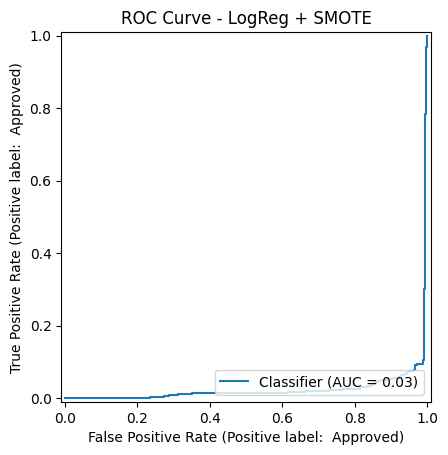

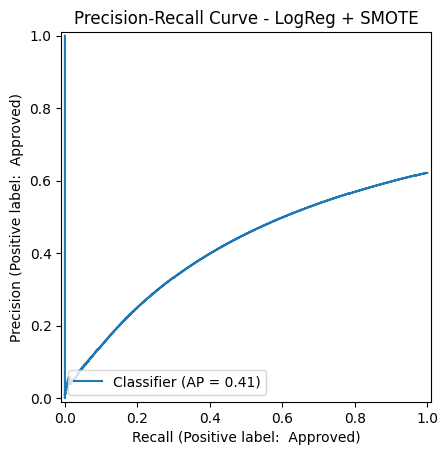


=== DecisionTree + SMOTE ===
              precision    recall  f1-score   support

    Approved     0.9849    0.9831    0.9840       531
    Rejected     0.9722    0.9752    0.9737       323

    accuracy                         0.9801       854
   macro avg     0.9786    0.9791    0.9789       854
weighted avg     0.9801    0.9801    0.9801       854

Confusion matrix:
 [[522   9]
 [  8 315]]
ROC-AUC: 0.9791
PR-AUC : 0.3280


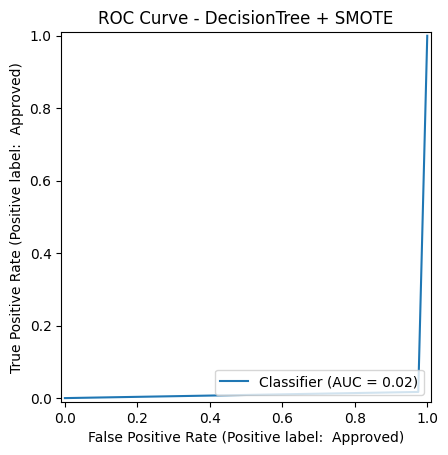

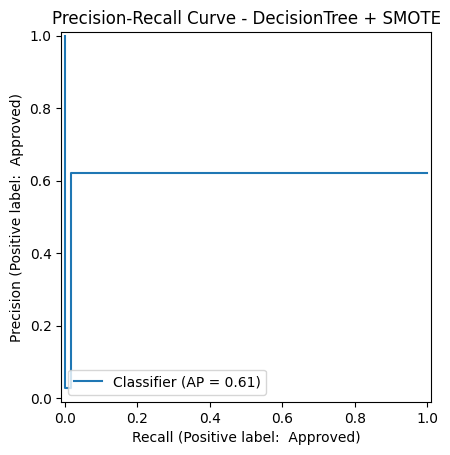

In [21]:

evaluate_on_test(pipe_lr_smote, X_train, y_train, X_test, y_test, name="LogReg + SMOTE")
evaluate_on_test(pipe_tree_smote, X_train, y_train, X_test, y_test, name="DecisionTree + SMOTE")



## 🔧 (Optional) Quick Hyperparameter Tweaks



DecisionTree (tuned) + SMOTE CV metrics (mean ± std):
  precision: nan ± nan
     recall: nan ± nan
         f1: nan ± nan
    roc_auc: 0.9933 ± 0.0013

=== DecisionTree (tuned) + SMOTE ===
              precision    recall  f1-score   support

    Approved     0.9942    0.9718    0.9829       531
    Rejected     0.9552    0.9907    0.9726       323

    accuracy                         0.9789       854
   macro avg     0.9747    0.9812    0.9778       854
weighted avg     0.9795    0.9789    0.9790       854

Confusion matrix:
 [[516  15]
 [  3 320]]
ROC-AUC: 0.9971
PR-AUC : 0.3416


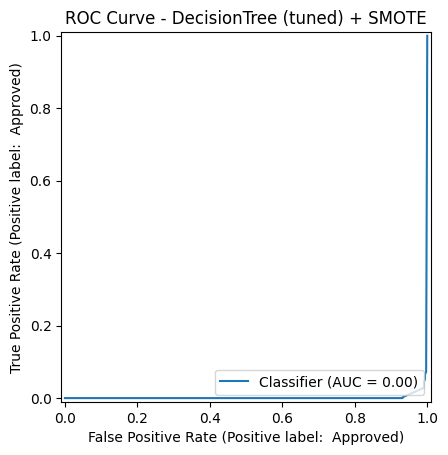

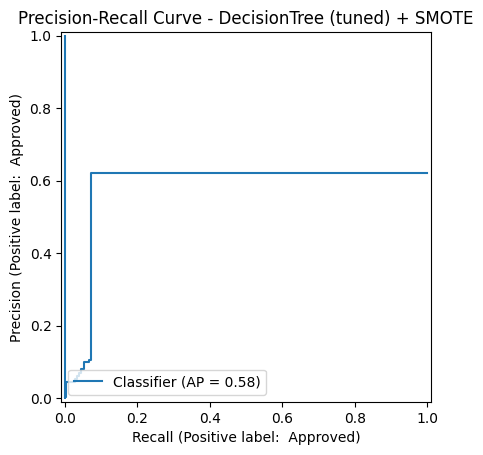

In [22]:

# Quick variant: a slightly tuned decision tree
tree_tuned = DecisionTreeClassifier(
    max_depth=6,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

pipe_tree_tuned_smote = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", smote),
    ("model", tree_tuned)
])

cv_tree_tuned_smote = cross_validate(pipe_tree_tuned_smote, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
summarize_cv(cv_tree_tuned_smote, "DecisionTree (tuned) + SMOTE")

evaluate_on_test(pipe_tree_tuned_smote, X_train, y_train, X_test, y_test, name="DecisionTree (tuned) + SMOTE")



## 💾 Save Your Best Model
Pick the pipeline that performed best and save it.


In [23]:

BEST_PIPELINE = pipe_lr_smote  # <- change if another performs better
BEST_PIPELINE.fit(X_train, y_train)
os.makedirs("artifacts", exist_ok=True)
joblib.dump(BEST_PIPELINE, "artifacts/loan_approval_best_model.joblib")
print("Saved to artifacts/loan_approval_best_model.joblib")


Saved to artifacts/loan_approval_best_model.joblib



## ✅ What to Report (in your submission / README)

- Which target column you used and its class distribution.
- How you handled **missing values** and **categorical encoding**.
- Baseline vs **SMOTE** performance (5‑fold CV): **precision**, **recall**, **F1** (and optionally ROC‑AUC, PR‑AUC).
- Final test‑set report (classification_report + confusion matrix).
- Brief comparison: **Logistic Regression** vs **Decision Tree** (when does each do better?).
- Screenshot of ROC and PR curves.
- Which model you selected as **best** and why.
